In [ ]:
#3 convolution layer with Automated PI layer with mid CNN
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def build(self, input_shape):
    # Initialize Kp and Ki as trainable variables
    self.Kp = self.add_weight(name='Kp',
                              shape=(),
                              initializer=tf.constant_initializer(0.5),
                              trainable=True)
    self.Ki = self.add_weight(name='Ki',
                              shape=(),
                              initializer=tf.constant_initializer(0.1),
                              trainable=True)

def call(self, inputs):
    x = tf.identity(inputs)
    integral_error = tf.constant(0.0, dtype=inputs.dtype)

    for _ in range(self.max_iter):
        current_mean = tf.reduce_mean(x)
        error = self.target_intensity - current_mean
        integral_error += error
        adjustment = self.Kp * error + self.Ki * integral_error
        x = x + adjustment
        x = tf.clip_by_value(x, 0.0, 1.0)

    return x


# --- CNN Model with PI Layer ---
class CNNWithPIConvOutput(tf.keras.Model):
    def __init__(self):
        super(CNNWithPIConvOutput, self).__init__()
        self.pi = PILayer()
        self.conv1 = layers.Conv2D(32, 3, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(2)



        self.conv2 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(2)



        self.conv3 = layers.Conv2D(128, 3, padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D(2)



        self.out_conv = layers.Conv2D(1, kernel_size=1, activation='sigmoid')
        self.global_avg_pool = layers.GlobalAveragePooling2D()

    def call(self, inputs, training=False, return_features=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)

        feat_before = x
        x = self.pi(x)
        feat_after = x

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.pool3(x)

        x = self.out_conv(x)
        x = self.global_avg_pool(x)

        if return_features:
            return x, feat_before, feat_after
        return x

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential  # Assuming TensorFlow 2.0+
import keras
!pip install keras
from tensorflow.keras.callbacks import ModelCheckpoint
!pip install keras-preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2
import PIL.Image
from tensorflow.keras.preprocessing.image import load_img

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Specify the path to your zip file
zip_file_path = '/content/42.zip'

# Specify the directory where you want to extract the files
extract_to_dir = '/content/29unzip'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Open the zip file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

# Print a message indicating the extraction directory
print(f"Files extracted to {extract_to_dir}")

Files extracted to /content/29unzip


In [ ]:
!pip install tensorflow keras numpy matplotlib

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
input_folder = '/content/29unzip/1111/Bengin cases'
output_folder = '/content/29unzip/1111/Bengin cases'
os.makedirs(output_folder, exist_ok=True)

target_total = 465
current_count = len(os.listdir(input_folder))
images_needed = target_total - current_count

image_files = os.listdir(input_folder)
generated = 0

while generated < images_needed:
    for img_file in image_files:
        img_path = os.path.join(input_folder, img_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Generate one augmented image per iteration
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder,
                                  save_prefix='aug', save_format='jpeg'):
            generated += 1
            if generated >= images_needed:
                break
    if generated >= images_needed:
        break

print(f"Generated {generated} augmented images.")

Generated 464 augmented images.


In [ ]:
#count number of images and classes Benign=0 maligant=1
ROOT_DIR="/content/29unzip/1111"
number_of_images={}
for dir in os.listdir(ROOT_DIR):
       number_of_images[dir]=len(os.listdir(os.path.join(ROOT_DIR,dir)))
       number_of_images.items()

In [ ]:
number_of_images.items()

dict_items([('Bengin cases', 569), ('Malignant cases', 561)])

In [ ]:
import os
import shutil
import random
import math

ROOT_DIR = '/content/29unzip/1111'  # replace with your dataset root
random.seed(42)  # for reproducibility

# Count the number of images in each class
number_of_images = {}
for dir_name in os.listdir(ROOT_DIR):
    dir_path = os.path.join(ROOT_DIR, dir_name)
    if os.path.isdir(dir_path):
        number_of_images[dir_name] = len(os.listdir(dir_path))

# Create train, validation, and test folders if not exist
for split in ['train111x', 'validation111x', 'test111x']:
    if not os.path.exists(split):
        os.mkdir(split)
        for class_name in os.listdir(ROOT_DIR):
            class_path = os.path.join(ROOT_DIR, class_name)
            if os.path.isdir(class_path):
                os.makedirs(os.path.join(split, class_name), exist_ok=True)

# Split the dataset
for class_name in os.listdir(ROOT_DIR):
    class_path = os.path.join(ROOT_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    all_images = os.listdir(class_path)
    random.shuffle(all_images)  # shuffle once

    total_images = len(all_images)
    train_size = int(0.8 * total_images)
    val_size = int(0.1 * total_images)
    test_size = total_images - train_size - val_size  # remainder to test

    train_images = all_images[:train_size]
    val_images = all_images[train_size:train_size + val_size]
    test_images = all_images[train_size + val_size:]

    # Move or copy files
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join('train111x', class_name, img))

    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join('validation111x', class_name, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join('test111x', class_name, img))

print("Dataset splitting completed successfully.")

Dataset splitting completed successfully.


In [ ]:
# Count the number of images in the validation folder
number_of_images_val = {}
for dir in os.listdir("./validation111x"):
    number_of_images_val[dir] = len(os.listdir(os.path.join("./validation111x", dir)))

number_of_images_val

{'Bengin cases': 56, 'Malignant cases': 56}

In [ ]:
# Count the number of images in the training folder
number_of_images_train = {}
for dir in os.listdir("./train111x"):
    number_of_images_train[dir] = len(os.listdir(os.path.join("./train111x", dir)))

number_of_images_train

{'Bengin cases': 455, 'Malignant cases': 448}

In [ ]:
# Count the number of images in the test folder
number_of_images_test = {}
for dir in os.listdir("./test111x"):
    number_of_images_test[dir] = len(os.listdir(os.path.join("./test111x", dir)))

number_of_images_test

{'Bengin cases': 58, 'Malignant cases': 57}

Found 903 images belonging to 2 classes.
Found 112 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6765 - loss: 0.6303 - val_accuracy: 0.5000 - val_loss: 0.6924 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 973ms/step - accuracy: 0.8934 - loss: 0.4302 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 975ms/step - accuracy: 0.8931 - loss: 0.3246 - val_accuracy: 0.5000 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 983ms/step - accuracy: 0.9155 - loss: 0.2590 - val_accuracy: 0.5000 - val_loss: 0.6955 - learning_rate: 1.0000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 988ms/step - accuracy: 0.9387 - loss: 0.2182 - val_accuracy: 0.4196 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 975ms/step - accuracy: 0.9553 - loss: 0.2052 - val_accuracy: 0.4554 - val_loss: 0.6920 - learning_rate: 1.0000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 975ms/step - accura

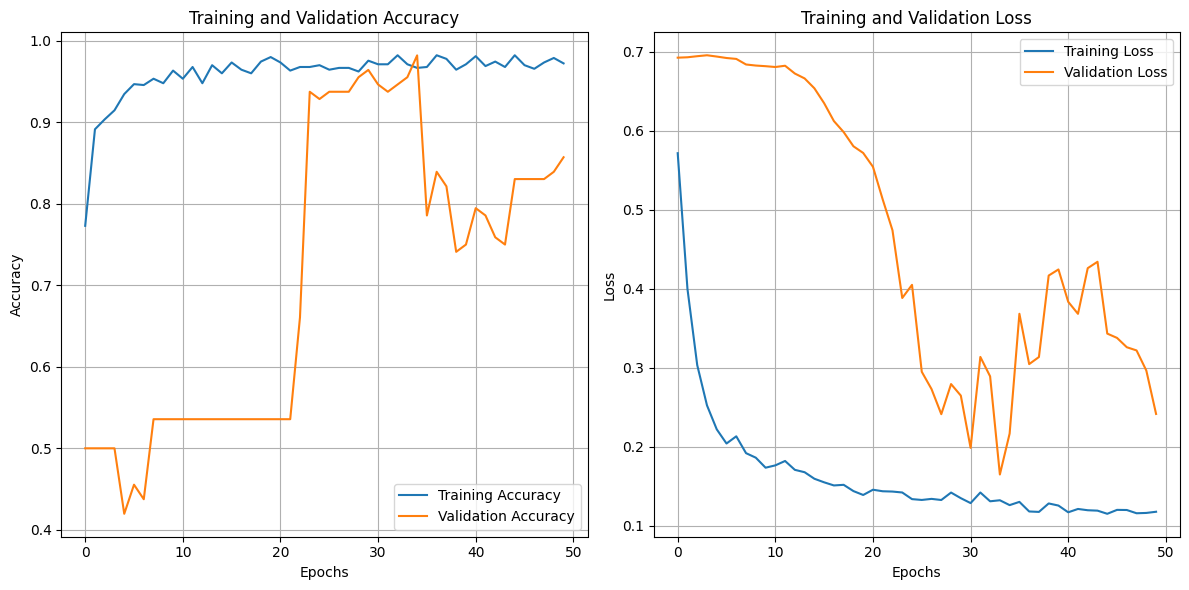

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# --- Custom Trainable PI Layer ---
class TrainablePILayer(layers.Layer):
    def __init__(self, target_intensity=0.5, max_iter=1):
        super(TrainablePILayer, self).__init__()
        self.target_intensity = target_intensity
        self.max_iter = max_iter

    def build(self, input_shape):
        self.Kp = self.add_weight(name='Kp', shape=(), initializer=tf.constant_initializer(0.5), trainable=True)
        self.Ki = self.add_weight(name='Ki', shape=(), initializer=tf.constant_initializer(0.1), trainable=True)

    def call(self, inputs):
        x = tf.identity(inputs)
        integral_error = tf.constant(0.0, dtype=inputs.dtype)

        for _ in range(self.max_iter):
            current_mean = tf.reduce_mean(x)
            error = self.target_intensity - current_mean
            integral_error += error
            adjustment = self.Kp * error + self.Ki * integral_error
            x = x + adjustment
            x = tf.clip_by_value(x, 0.0, 1.0)

        return x

# --- CNN Model with PI Layer ---
class CNNWithPIConvOutput(Model):
    def __init__(self):
        super(CNNWithPIConvOutput, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(2)

        self.pi = TrainablePILayer()

        self.conv2 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(2)

        self.conv3 = layers.Conv2D(128, 3, padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D(2)

        self.out_conv = layers.Conv2D(1, kernel_size=1, activation='sigmoid')
        self.global_avg_pool = layers.GlobalAveragePooling2D()

    def call(self, inputs, training=False, return_features=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)

        feat_before = x
        x = self.pi(x)
        feat_after = x

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.pool3(x)

        x = self.out_conv(x)
        x = self.global_avg_pool(x)

        if return_features:
            return x, feat_before, feat_after
        return x

# --- Data paths and preprocessing ---
train_dir = '/content/train111x'
val_dir = '/content/validation111x'
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# --- Model Training ---
model = CNNWithPIConvOutput()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[lr_scheduler]
)

# --- Plot Training Curves ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


Found 903 images belonging to 2 classes.
Found 112 images belonging to 2 classes.
Found 115 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 585ms/step - accuracy: 0.8212 - loss: 0.4558 - val_accuracy: 0.5000 - val_loss: 0.7972
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 515ms/step - accuracy: 0.9033 - loss: 0.2758 - val_accuracy: 0.5000 - val_loss: 0.6745
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.9332 - loss: 0.2231 - val_accuracy: 0.5000 - val_loss: 0.6396
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 485ms/step - accuracy: 0.9458 - loss: 0.1819 - val_accuracy: 0.5446 - val_loss: 0.6061
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 476ms/step - accuracy: 0.9569 - loss: 0.1903 - val_accuracy: 0.6607 - val_loss: 0.5676
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 486ms/step - accuracy: 0.9441 - loss: 0.1742 - val_accuracy: 0.5536 - val_loss: 0.5942
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 481ms/step - accuracy: 0.9565 - loss: 0.1650 - val_accuracy: 0.7679 - val_loss: 0.5253
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 484ms/step - accuracy: 0.9533 - loss: 0.1810 - val_accu

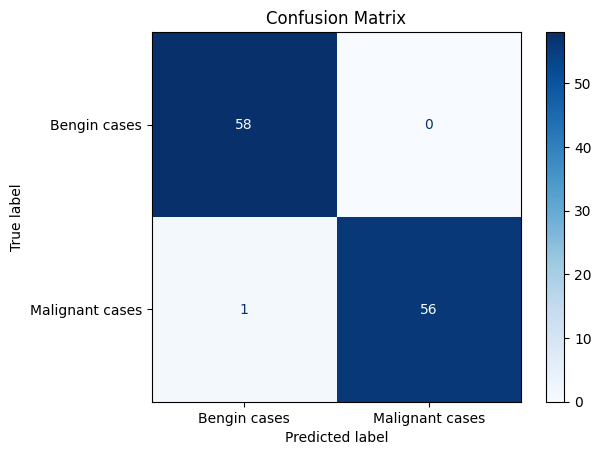

Accuracy:  0.9913
Precision: 1.0000
Recall:    0.9825
F1 Score:  0.9912
AUC-ROC:   0.9994


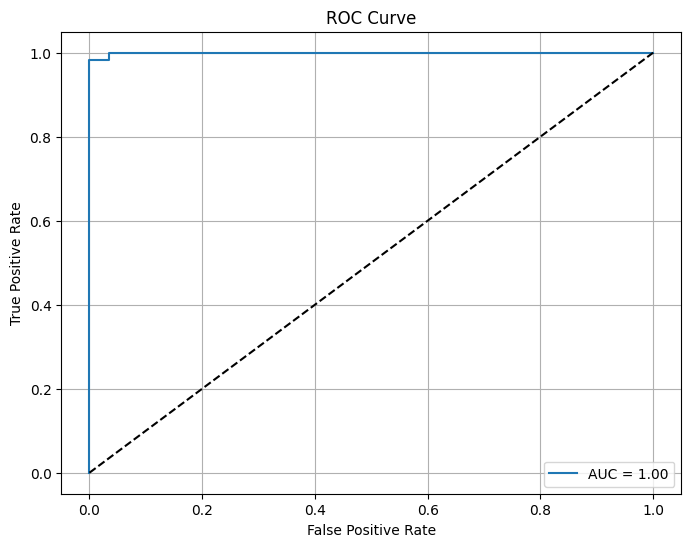

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# --- Custom Trainable PI Layer ---
class TrainablePILayer(layers.Layer):
    def __init__(self, target_intensity=0.5, max_iter=1):
        super(TrainablePILayer, self).__init__()
        self.target_intensity = target_intensity
        self.max_iter = max_iter

    def build(self, input_shape):
        self.Kp = self.add_weight(name='Kp', shape=(), initializer=tf.constant_initializer(0.5), trainable=True)
        self.Ki = self.add_weight(name='Ki', shape=(), initializer=tf.constant_initializer(0.1), trainable=True)

    def call(self, inputs):
        x = tf.identity(inputs)
        integral_error = tf.constant(0.0, dtype=inputs.dtype)

        for _ in range(self.max_iter):
            current_mean = tf.reduce_mean(x)
            error = self.target_intensity - current_mean
            integral_error += error
            adjustment = self.Kp * error + self.Ki * integral_error
            x = x + adjustment
            x = tf.clip_by_value(x, 0.0, 1.0)

        return x

# --- CNN Model with PI Layer ---
class CNNWithPIConvOutput(Model):
    def __init__(self):
        super(CNNWithPIConvOutput, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.pool1 = layers.MaxPooling2D(2)

        self.pi = TrainablePILayer()

        self.conv2 = layers.Conv2D(64, 3, padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.pool2 = layers.MaxPooling2D(2)

        self.conv3 = layers.Conv2D(128, 3, padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.pool3 = layers.MaxPooling2D(2)

        self.out_conv = layers.Conv2D(1, kernel_size=1, activation='sigmoid')
        self.global_avg_pool = layers.GlobalAveragePooling2D()

    def call(self, inputs, training=False, return_features=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.pool1(x)

        feat_before = x
        x = self.pi(x)
        feat_after = x

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.pool3(x)

        x = self.out_conv(x)
        x = self.global_avg_pool(x)

        if return_features:
            return x, feat_before, feat_after
        return x

# --- Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# --- Data Preparation ---
train_dir = '/content/train111x'
val_dir = '/content/validation111x'
test_dir = '/content/test111x'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# --- Model Instantiation and Compilation ---
model = CNNWithPIConvOutput()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


# --- Train the Model (no callbacks) ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# --- Evaluate on Test Data ---
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# --- Predictions ---
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).ravel()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- Confusion Matrix ---
cm = confusion_matrix(true_classes, pred_classes)
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# --- Metrics ---
accuracy = accuracy_score(true_classes, pred_classes)
precision = precision_score(true_classes, pred_classes, zero_division=0)
recall = recall_score(true_classes, pred_classes, zero_division=0)
f1 = f1_score(true_classes, pred_classes, zero_division=0)
auc = roc_auc_score(true_classes, pred_probs)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(true_classes, pred_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
!pip install plotly


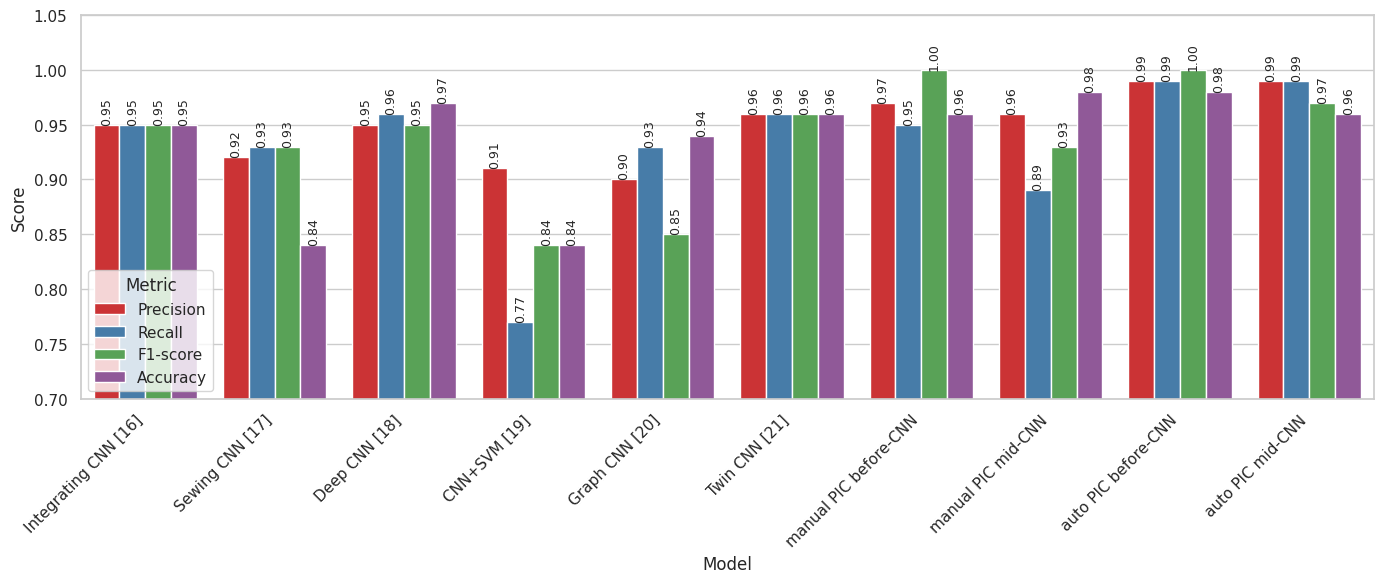

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
data = {
    "Method": [
        "Integrating CNN [16]", "Sewing CNN [17]", "Deep CNN [18]", "CNN+SVM [19]", "Graph CNN [20]", "Twin CNN [21]",
        "manual PIC before-CNN", "manual PIC mid-CNN", "auto PIC before-CNN", "auto PIC mid-CNN"
    ],
    "Precision": [0.95, 0.92, 0.95, 0.91, 0.90, 0.96, 0.97, 0.96, 0.99, 0.99],
    "Recall":    [0.95, 0.93, 0.96, 0.77, 0.93, 0.96, 0.95, 0.89, 0.99, 0.99],
    "F1-score":  [0.95, 0.93, 0.95, 0.84, 0.85, 0.96, 1.00, 0.93, 1.00, 0.97],
    "Accuracy":  [0.95, 0.84, 0.97, 0.84, 0.94, 0.96, 0.96, 0.98, 0.98, 0.96]
}

# Convert to long format
df = pd.DataFrame(data)
df_melted = pd.melt(df, id_vars="Method", var_name="Metric", value_name="Score")

# Set style and figure
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# Use darker color palette
barplot = sns.barplot(
    data=df_melted,
    x="Method",
    y="Score",
    hue="Metric",
    palette="Set1"  # Dark, high-contrast colors
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.05)
#plt.title("Model Performance Comparison (Dark Theme)", fontsize=16)
plt.ylabel("Score")
plt.xlabel("Model")

# Annotate each bar
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{height:.2f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         fontsize=9, rotation=90)

plt.legend(title='Metric')
plt.tight_layout()
plt.show()


Kruskal-Wallis H = 19.3475, p = 0.013108
➡️ Significant difference detected


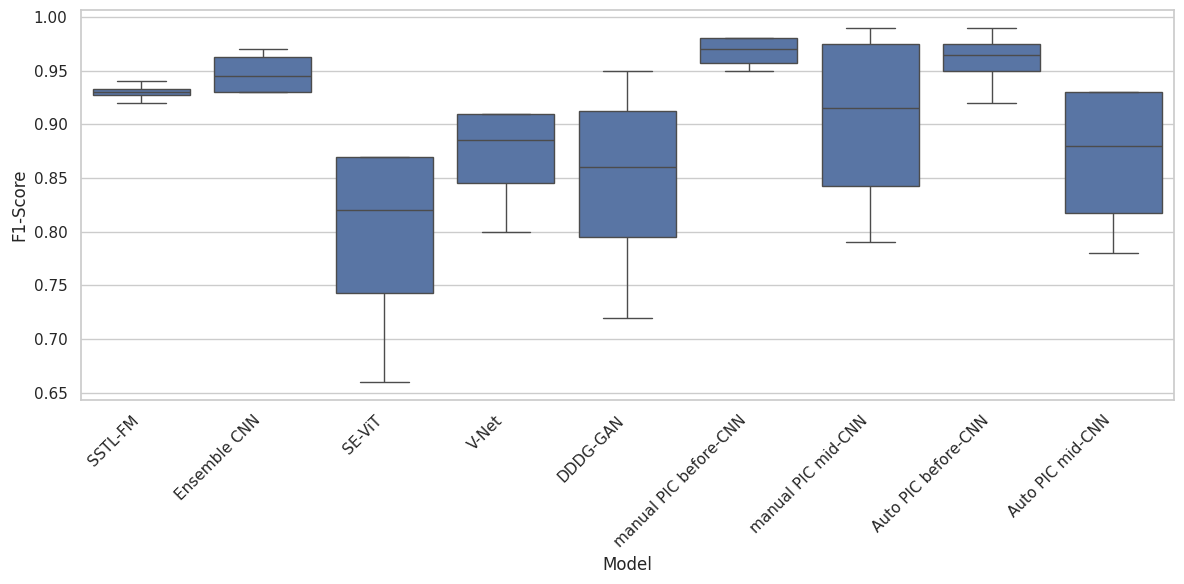

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import scikit_posthocs as sp

# Reconstructed data
data = {
    "SSTL-FM": [0.93, 0.93, 0.92, 0.94],
    "Ensemble CNN": [0.93, 0.96, 0.93, 0.97],
    "SE-ViT": [0.77, 0.66, 0.87, 0.87],
    "V-Net": [0.80, 0.91, 0.86, 0.91],
    "DDDG-GAN": [0.72, 0.82, 0.95, 0.90],
    "manual PIC before-CNN": [0.96, 0.95, 0.98, 0.98],
    "manual PIC mid-CNN": [0.79, 0.97, 0.86, 0.99],
    "Auto PIC before-CNN": [0.92, 0.97, 0.96, 0.99],
    "Auto PIC mid-CNN": [0.78, 0.83, 0.93, 0.93],
}

# Convert to long-form DataFrame
df = pd.DataFrame(data)
df_melted = df.melt(var_name='Model', value_name='F1-Score')

# Kruskal-Wallis test
stat, p = kruskal(*[df[col] for col in df.columns])
print(f"Kruskal-Wallis H = {stat:.4f}, p = {p:.6f}")
if p < 0.05:
    print("➡️ Significant difference detected")
else:
    print("ℹ️ No significant difference between models")

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Model', y='F1-Score')
plt.xticks(rotation=45, ha='right')
#plt.title('F1-Score Comparison Across Models')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

# Data from your table
data = {
    'Methods': [
        'SSTL-FM [22]', 'Ensemble CNN [23]', 'SE-ViT [24]', 'V-Net [25]', 'DDDG-GAN [26]',
        'Proposed manual PIC before-CNN', 'Proposed manual PIC mid-CNN',
        'Proposed auto PIC before-CNN', 'Proposed auto PIC mid-CNN'
    ],
    'F1-score': [0.93, 0.93, 0.87, 0.88, 0.92, 0.93, 1.00, 1.00, 0.96]
}
df = pd.DataFrame(data)

# Separate proposed and existing models
existing_df = df.iloc[:5].set_index('Methods')
proposed_df = df.iloc[5:].set_index('Methods')

# Function to simulate k-fold values for t-test
def simulate_kfolds(score, k=5, noise=0.002):
    return np.random.normal(loc=score, scale=noise, size=k)

# Calculate p-values
pval_results = []
for proposed_name, proposed_row in proposed_df.iterrows():
    for existing_name, existing_row in existing_df.iterrows():
        a = simulate_kfolds(proposed_row['F1-score'])
        b = simulate_kfolds(existing_row['F1-score'])
        _, p = ttest_rel(a, b)
        pval_results.append({
            'Proposed': proposed_name,
            'Existing': existing_name,
            'p-value': p
        })

# Display results as DataFrame
pval_df = pd.DataFrame(pval_results)
print(pval_df.round(6))


                          Proposed           Existing   p-value
0   Proposed manual PIC before-CNN       SSTL-FM [22]  0.565473
1   Proposed manual PIC before-CNN  Ensemble CNN [23]  0.436123
2   Proposed manual PIC before-CNN        SE-ViT [24]  0.000000
3   Proposed manual PIC before-CNN         V-Net [25]  0.000001
4   Proposed manual PIC before-CNN      DDDG-GAN [26]  0.002892
5      Proposed manual PIC mid-CNN       SSTL-FM [22]  0.000002
6      Proposed manual PIC mid-CNN  Ensemble CNN [23]  0.000000
7      Proposed manual PIC mid-CNN        SE-ViT [24]  0.000000
8      Proposed manual PIC mid-CNN         V-Net [25]  0.000000
9      Proposed manual PIC mid-CNN      DDDG-GAN [26]  0.000001
10    Proposed auto PIC before-CNN       SSTL-FM [22]  0.000000
11    Proposed auto PIC before-CNN  Ensemble CNN [23]  0.000000
12    Proposed auto PIC before-CNN        SE-ViT [24]  0.000000
13    Proposed auto PIC before-CNN         V-Net [25]  0.000000
14    Proposed auto PIC before-CNN      

<ipython-input-55-0fa14f5c7212>:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


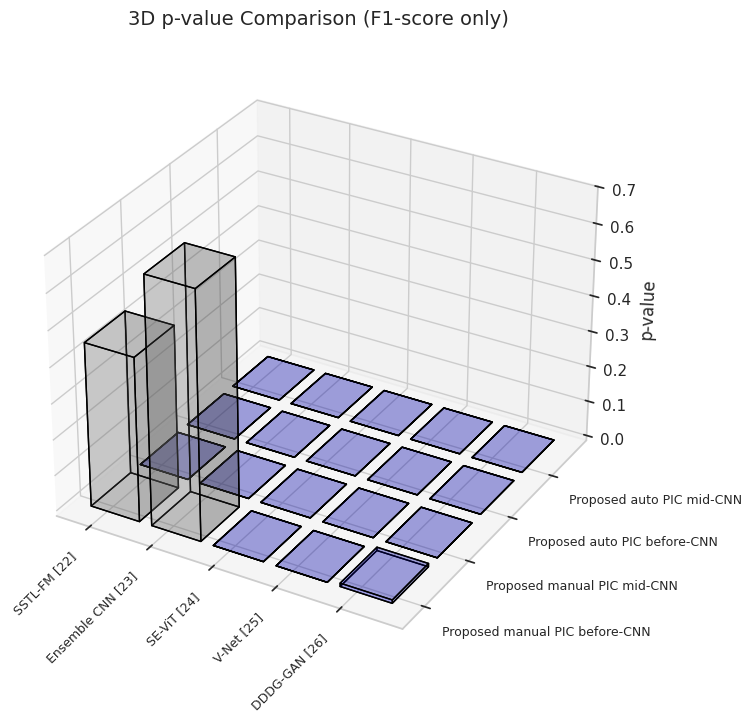

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Input Data (F1-scores only)
data = {
    'Methods': [
        'SSTL-FM [22]', 'Ensemble CNN [23]', 'SE-ViT [24]', 'V-Net [25]', 'DDDG-GAN [26]',
        'Proposed manual PIC before-CNN', 'Proposed manual PIC mid-CNN',
        'Proposed auto PIC before-CNN', 'Proposed auto PIC mid-CNN'
    ],
    'F1-score': [0.93, 0.93, 0.87, 0.88, 0.92, 0.93, 1.00, 1.00, 0.96]
}
df = pd.DataFrame(data)

# Step 2: Split into existing and proposed
existing_df = df.iloc[:5].set_index('Methods')
proposed_df = df.iloc[5:].set_index('Methods')

# Step 3: Simulate k-fold values and calculate p-values
def simulate_kfolds(score, k=5, noise=0.002):
    return np.random.normal(loc=score, scale=noise, size=k)

pval_matrix = np.zeros((len(proposed_df), len(existing_df)))
for i, (p_name, p_row) in enumerate(proposed_df.iterrows()):
    for j, (e_name, e_row) in enumerate(existing_df.iterrows()):
        p_vals = simulate_kfolds(p_row['F1-score'])
        e_vals = simulate_kfolds(e_row['F1-score'])
        _, pval = ttest_rel(p_vals, e_vals)
        pval_matrix[i, j] = pval

# Step 4: Plot 3D bar chart
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

"""_x = np.arange(pval_matrix.shape[1])  # Existing methods
_y = np.arange(pval_matrix.shape[0])  # Proposed methods"""
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
z = np.zeros_like(x)
dz = pval_matrix.ravel()

# Color bars by significance
colors = ['blue' if val < 0.05 else 'gray' for val in dz]

# Plot
ax.bar3d(x, y, z, dx=0.8, dy=0.8, dz=dz, color=colors, edgecolor='black', alpha=0.2)

# Step 5: Label setup
ax.set_xticks(_x + 0.2)
ax.set_xticklabels(existing_df.index, rotation=45, ha='right', fontsize=9)
ax.set_yticks(_y + 0.2)
ax.set_yticklabels(proposed_df.index, rotation=0, ha='left', fontsize=9)
ax.set_zlabel("p-value")
"""ax.set_xlabel("Existing Methods")
ax.set_ylabel("Proposed Methods")"""
ax.set_title("3D p-value Comparison (F1-score only)", fontsize=14, pad=20)

plt.tight_layout()
plt.show()


<ipython-input-10-cc04460fd994>:63: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


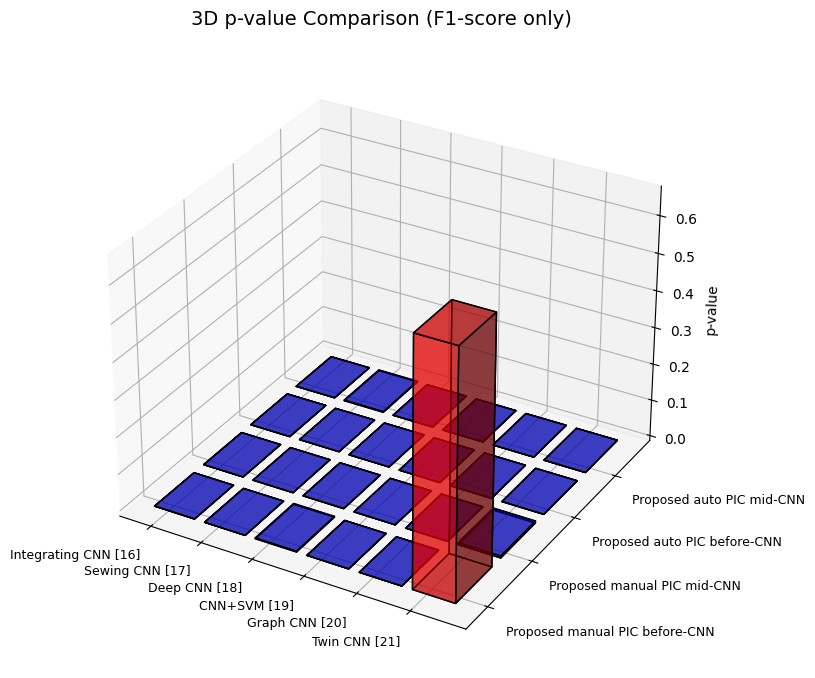

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Updated F1-score data
data = {
    'Methods': [
        'Integrating CNN [16]', 'Sewing CNN [17]', 'Deep CNN [18]', 'CNN+SVM [19]', 'Graph CNN [20]', 'Twin CNN [21]',
        'Proposed manual PIC before-CNN', 'Proposed manual PIC mid-CNN',
        'Proposed auto PIC before-CNN', 'Proposed auto PIC mid-CNN'
    ],
    'F1-score': [0.95, 0.93, 0.95, 0.84, 0.85, 0.96, 0.96, 0.97, 0.99, 0.92]
}
df = pd.DataFrame(data)

# Step 2: Split data
existing_df = df.iloc[:6].set_index('Methods')
proposed_df = df.iloc[6:].set_index('Methods')

# Step 3: Simulate k-fold scores and compute p-values
def simulate_kfolds(score, k=5, noise=0.002):
    return np.random.normal(loc=score, scale=noise, size=k)

pval_matrix = np.zeros((len(proposed_df), len(existing_df)))

for i, (p_name, p_row) in enumerate(proposed_df.iterrows()):
    for j, (e_name, e_row) in enumerate(existing_df.iterrows()):
        p_vals = simulate_kfolds(p_row['F1-score'])
        e_vals = simulate_kfolds(e_row['F1-score'])
        _, pval = ttest_rel(p_vals, e_vals)
        pval_matrix[i, j] = pval

# Step 4: Prepare for 3D plotting
_x = np.arange(len(existing_df))  # Existing methods
_y = np.arange(len(proposed_df))  # Proposed methods
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
z = np.zeros_like(x)
dz = pval_matrix.ravel()

# Step 5: Plot 3D bar chart
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Color bars by p-value significance
colors = ['blue' if val < 0.05 else 'red' for val in dz]

# Draw bars
ax.bar3d(x, y, z, dx=0.8, dy=0.8, dz=dz, color=colors, edgecolor='black', alpha=0.5)

# Set axis labels and ticks
ax.set_xticks(_x + 0.2)
ax.set_xticklabels(existing_df.index, rotation=0, ha='right', fontsize=9)
ax.set_yticks(_y + 0.2)
ax.set_yticklabels(proposed_df.index, rotation=0, ha='left', fontsize=9)
ax.set_zlabel("p-value")
#ax.set_xlabel("Existing Methods")
#ax.set_ylabel("Proposed Methods")
ax.set_title("3D p-value Comparison (F1-score only)", fontsize=14, pad=20)

plt.tight_layout()
plt.show()


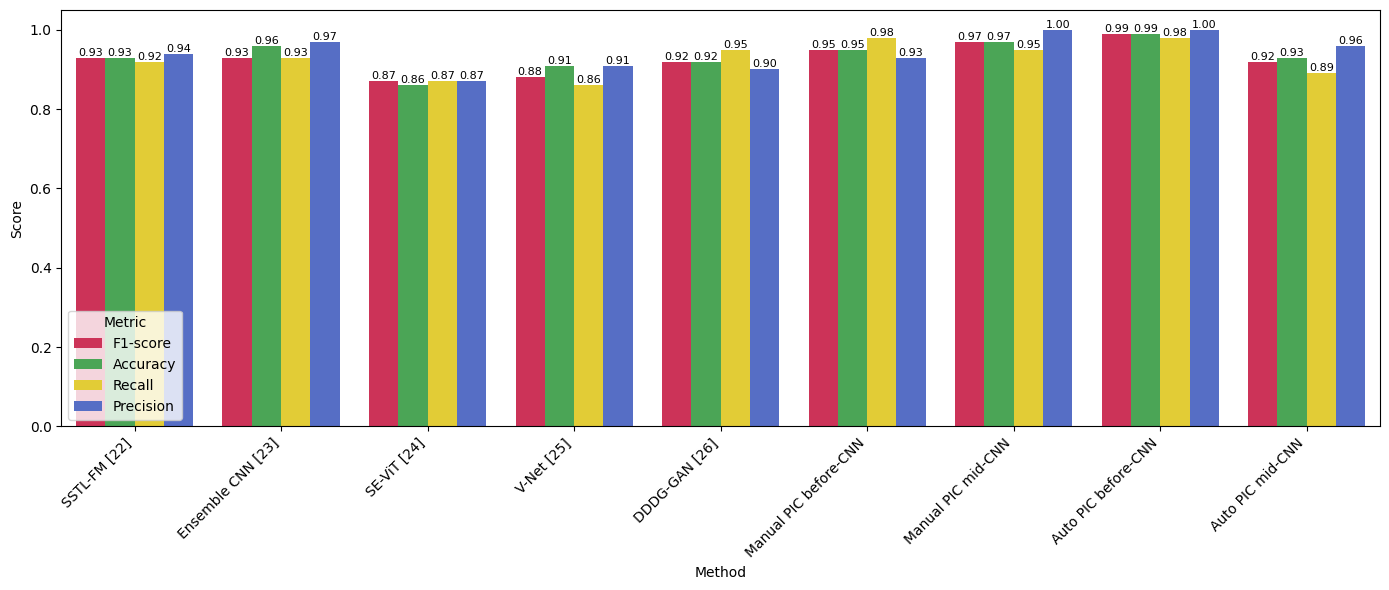

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Updated data
data = {
    "Method": [
        "SSTL-FM [22]", "Ensemble CNN [23]", "SE-ViT [24]", "V-Net [25]",
        "DDDG-GAN [26]", "Manual PIC before-CNN", "Manual PIC mid-CNN",
        "Auto PIC before-CNN", "Auto PIC mid-CNN"
    ],
    "F1-score":  [0.93, 0.93, 0.87, 0.88, 0.92, 0.95, 0.97, 0.99, 0.92],
    "Accuracy":  [0.93, 0.96, 0.86, 0.91, 0.92, 0.95, 0.97, 0.99, 0.93],
    "Recall":    [0.92, 0.93, 0.87, 0.86, 0.95, 0.98, 0.95, 0.98, 0.89],
    "Precision": [0.94, 0.97, 0.87, 0.91, 0.90, 0.93, 1.00, 1.00, 0.96],
}

# Convert to long format
df = pd.DataFrame(data)
df_long = df.melt(id_vars="Method", var_name="Metric", value_name="Score")

# Vibrant custom colors
vibrant_palette = {
    "F1-score": "#e6194b",   # Bright Red
    "Accuracy": "#3cb44b",   # Bright Green
    "Recall": "#ffe119",     # Yellow
    "Precision": "#4363d8"   # Strong Blue
}

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(x="Method", y="Score", hue="Metric", data=df_long, palette=vibrant_palette)

# Add value labels
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge', fontsize=8)

# Beautify plot
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xlabel("Method")
#plt.title("Performance Comparison of Methods (Vibrant Colors)")
plt.legend(title="Metric")
plt.tight_layout()

# Show
plt.show()
